# CPR_CLD_2A

Import libraries:

In [1]:
from pystac_client import Client
import fsspec
import xarray as xr
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd 
import requests
from IPython.display import Image, display
import os 
import pathlib
from tqdm import tqdm


### ESA MAAP (STAC) Catalog API 
Point to the catalogue endpoint

In [2]:
catalog_url = 'https://catalog.maap.eo.esa.int/catalogue/'
catalog = Client.open(catalog_url)

In [3]:
EC_COLLECTION = ['EarthCAREL2Validated_MAAP']

**Filter** - allows you to search based on different metadata parameters. To understand which queryables exist you can visit: [Queryables](https://catalog.maap.eo.esa.int/catalogue/collections/EarthCAREL1Validated_MAAP/queryables). 
Examples include: 
* productType
* frame 
* processingLevel
* instrument
* orbitNumber 
... 

**Datetime** represents the temporal coverage of the data. None can be used for both start and end to indicated unbounded queries.  

**bbox** is defined by the bottom left corner (longmin latmin) and the top right corner coordinates (longmax latmax) 


In [4]:
search = catalog.search(
    collections=EC_COLLECTION, 
    filter="productType = 'CPR_CLD_2A' and (frame = 'E' or frame = 'A')", # Filter by product type
    bbox = [100, -15, 160, 30],
    #datetime = ['2025-06-06T00:00:00Z', None] 
    method = 'GET', # This is necessary 
    max_items=1e3 #5  # Adjust as needed, given the large aoutn of products it is recommended to set a limit
)

items = list(search.items())
print(f"Accessing {len(items)} items (limited by max_items).")
print(f"{search.matched()} items found that matched the query.")

Accessing 841 items (limited by max_items).
841 items found that matched the query.


This can become a function later on:

In [5]:
# Using Pandas dataframes for ease of use. This is not mandatory, but just a nice way to get an overview of the products you found through the search. Please note that pandas dataframes run into issues if we try to pass to many products. Use max_items! :) 
data = search.item_collection_as_dict()

df = pd.json_normalize(data, record_path=['features'])[
    [
        "id",
        "properties.product:type",                
        "properties.updated",                     
        "assets.product.href",
        #"assets.thumbnail.href",
        "assets.quicklook.href",
        "assets.enclosure_1.href",
        "assets.enclosure_2.href",
    ]
]

# Renaming the assets for 
df.rename(columns={
    'properties.product:type': 'product_type',
    'properties.updated': 'last_modified',
    'assets.product.href': 'Zipped Product',
    #'assets.thumbnail.href': 'thumbnail_url',
    'assets.quicklook.href': 'quicklook_url',
    'assets.enclosure_1.href': 'h5_url',
    'assets.enclosure_2.href': 'HDR_url',
}, inplace=True)

df.sort_values(by='id', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)


In [6]:
df

,id,product_type,last_modified,Zipped Product,quicklook_url,h5_url,HDR_url
0,ECA_EXAB_CPR_CLD_2A_20250311T035711Z_20250311T...,CPR_CLD_2A,2025-09-12T07:27:14Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
1,ECA_EXAB_CPR_CLD_2A_20250311T052943Z_20250311T...,CPR_CLD_2A,2025-09-12T07:27:17Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
2,ECA_EXAB_CPR_CLD_2A_20250311T070215Z_20250311T...,CPR_CLD_2A,2025-09-12T07:27:19Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
3,ECA_EXAB_CPR_CLD_2A_20250311T153117Z_20250311T...,CPR_CLD_2A,2025-09-12T07:27:36Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
4,ECA_EXAB_CPR_CLD_2A_20250311T170349Z_20250311T...,CPR_CLD_2A,2025-09-12T07:27:39Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
...,...,...,...,...,...,...,...
836,ECA_EXBA_CPR_CLD_2A_20250922T033703Z_20250922T...,CPR_CLD_2A,2025-09-23T09:28:55Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
837,ECA_EXBA_CPR_CLD_2A_20250922T050935Z_20250922T...,CPR_CLD_2A,2025-09-23T09:28:57Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
838,ECA_EXBA_CPR_CLD_2A_20250922T151109Z_20250922T...,CPR_CLD_2A,2025-09-23T09:29:15Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...
839,ECA_EXBA_CPR_CLD_2A_20250922T164342Z_20250922T...,CPR_CLD_2A,2025-09-23T09:29:19Z,https://catalog.maap.eo.esa.int/data/zipper/ea...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...,https://catalog.maap.eo.esa.int/data/earthcare...


## Quicklook of the data

In [7]:
# Choose the file you want to view/stream/download 

fileno = 456 #2 # Adjust this as desired 
ql_url = df.loc[fileno, "quicklook_url"]
# Note: thumbnail is a lower resolution version
display(Image(url= ql_url))


### Token
You can generate the token [here](https://portal.maap.eo.esa.int/ini/services/auth/token/index.php). Currently this is only valid for 10 h! 


In [10]:
with open("token.txt","rt") as f:
    token = f.read().strip().replace("\n","")

The **CPR_CLD_2A**'s data is contained in ScienceData: 

In [11]:
ds_url = df.loc[fileno, "h5_url"]
print(ds_url)
#ds_url = 'https://catalog.maap.eo.esa.int/data/earthcare-pdgs-01/EarthCARE/BBR_NOM_1B/BA/2025/06/06/ECA_EXBA_BBR_NOM_1B_20250606T004221Z_20250606T011729Z_05805B/ECA_EXBA_BBR_NOM_1B_20250606T004221Z_20250606T011729Z_05805B/ECA_EXBA_BBR_NOM_1B_20250606T004221Z_20250606T011729Z_05805B.h5'


https://catalog.maap.eo.esa.int/data/earthcare-pdgs-01/EarthCARE/CPR_CLD_2A/AB/2025/05/31/ECA_EXAB_CPR_CLD_2A_20250531T145705Z_20250531T172208Z_05721A/ECA_EXAB_CPR_CLD_2A_20250531T145705Z_20250531T172208Z_05721A/ECA_EXAB_CPR_CLD_2A_20250531T145705Z_20250531T172208Z_05721A.h5


In [12]:
fs = fsspec.filesystem("https", headers={"Authorization": f"Bearer {token}"})
with fs.open(ds_url, "rb") as f:
    ds = xr.open_dataset(f, engine="h5netcdf", group="ScienceData").compute()
ds
# Do somethign with ds 

<xarray.Dataset> Size: 120MB
Dimensions:                                           (along_track: 4896,
                                                       CPR_height: 218)
Dimensions without coordinates: along_track, CPR_height
Data variables: (12/51)
    time                                              (along_track) datetime64[ns] 39kB ...
    latitude                                          (along_track) float64 39kB ...
    longitude                                         (along_track) float64 39kB ...
    height                                            (along_track, CPR_height) float32 4MB ...
    geoid_offset                                      (along_track) float32 20kB ...
    surface_elevation                                 (along_track) float32 20kB ...
    ...                                                ...
    liquid_effective_radius                           (along_track, CPR_height) float32 4MB ...
    liquid_effective_radius_relative_error            (along_track, CPR_height) float32 4MB ...
    liquid_water_path                                 (along_track) float32 20kB ...
    liquid_water_path_error                           (along_track) float32 20kB ...
    drizzle_mass_flux                                 (along_track) float32 20kB ...
    drizzle_mass_flux_log_error                       (along_track) float32 20kB ...

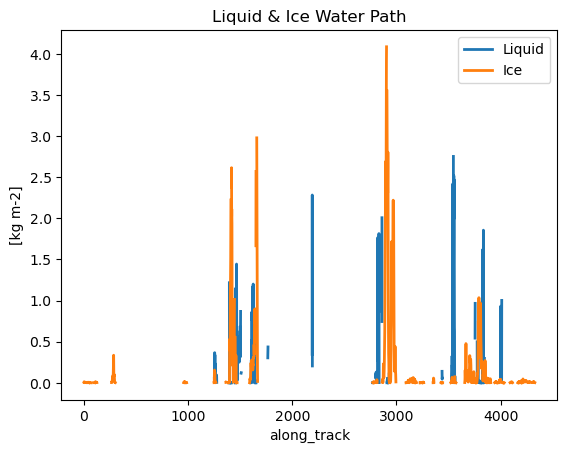

In [13]:
ds['liquid_water_path'].plot(label='Liquid', linewidth=2)
ds['ice_water_path'].plot(label='Ice', linewidth=2)
plt.legend()
plt.ylabel("[kg m-2]")
plt.title('Liquid & Ice Water Path')
plt.show()

## Let's loop!!

In [14]:
len(df)

841

In [15]:
nooffiles = len(df) #silly name
# nooffiles = 10 #testing

In [16]:
frames = []
for fileno in tqdm(range(nooffiles)):
    # print(fileno)
    
    ds_url = df.loc[fileno, "h5_url"]
    
    fs = fsspec.filesystem("https", headers={"Authorization": f"Bearer {token}"})
    with fs.open(ds_url, "rb") as f:
        
        # Open the data
        ds = xr.open_dataset(f, engine="h5netcdf", group="ScienceData").compute()
        
        # Get the variables
        selection = ds[['latitude', 'longitude', 'land_flag', 'ice_water_path', 'liquid_water_path']]
        # Set unique coordinate to along track dimension
        selection = selection.assign_coords(along_track=ds['time'])
        selection = selection.rename({"along_track":"time"})

        frames.append(selection)


00%|██████████| 841/841 [27:13<00:00,  1.94s/it] 

In [25]:
radar = xr.concat(frames, dim='time').sortby('time')

In [26]:
radar_1s = radar.resample(time='1s').mean().dropna(dim='time', how='all')
radar_1s

<xarray.Dataset> Size: 23MB
Dimensions:            (time: 581852)
Coordinates:
  * time               (time) datetime64[ns] 5MB 2025-03-11T03:57:14 ... 2025...
Data variables:
    latitude           (time) float64 5MB 22.59 22.53 22.47 ... 22.5 22.56 22.61
    longitude          (time) float64 5MB 153.1 153.1 153.1 ... 109.2 109.1
    land_flag          (time) float64 5MB 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0
    ice_water_path     (time) float32 2MB nan nan nan nan ... nan nan nan nan
    liquid_water_path  (time) float32 2MB nan nan nan nan ... nan nan nan nan

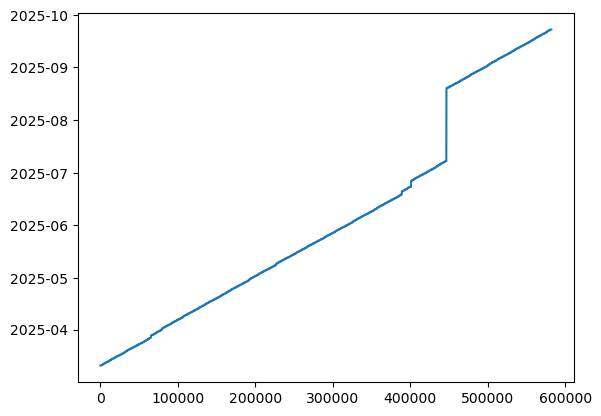

In [27]:
plt.plot(radar_1s.indexes['time'])

In [28]:
radar_1s.time

<xarray.DataArray 'time' (time: 581852)> Size: 5MB
array(['2025-03-11T03:57:14.000000000', '2025-03-11T03:57:15.000000000',
       '2025-03-11T03:57:16.000000000', ..., '2025-09-22T18:27:54.000000000',
       '2025-09-22T18:27:55.000000000', '2025-09-22T18:27:56.000000000'],
      shape=(581852,), dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 5MB 2025-03-11T03:57:14 ... 2025-09-22T18:...
Attributes:
    long_name:  Time

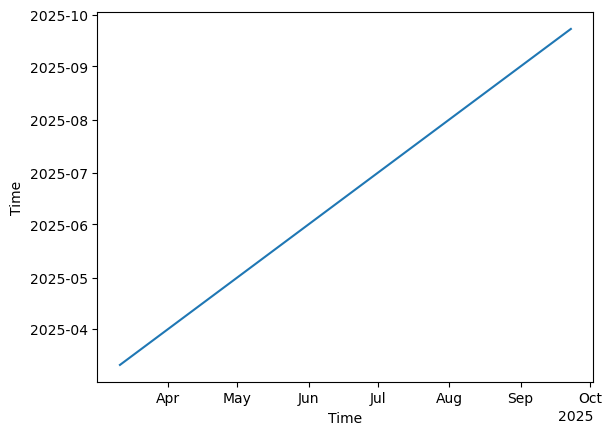

In [29]:
radar_1s.time.plot()


## Save a netCDF file:

In [30]:
radar_1s.to_netcdf('CPR_CLD_2A_1s.nc')

In [31]:
%cp "CPR_CLD_2A_1s.nc" "/home/jovyan/my-private-bucket/."